In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

sns.set_theme(font="Arial", style="white", context="poster")

In [2]:

def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[
        ((design_matrix['Sepsis Prob'] >= 0.8) | 
        (design_matrix['Sepsis Prob'] <= 0.50))
    ].copy()

    design_matrix['group'] = np.where(
        design_matrix['Sepsis Prob'] > 0.65, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]


    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()     


In [4]:
def preprocess_test_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()   

# Model Training

In [5]:
ms_data = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)

In [6]:
design_matrix_otrain = pd.read_csv(
    "../1_clinical_digital_family/design_matrix_test_sepsis_risk.tsv",
    sep='\t'
)

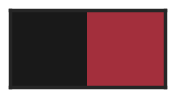

In [7]:
custom_palette = ["k", "#A32F3C"]  # Define hex colors
palette = sns.color_palette(custom_palette, as_cmap=True)
sns.palplot(custom_palette)

In [8]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

In [9]:
quant_matrix_train_lr = preprocess_data(ms_data, design_matrix=design_matrix_train)
quant_matrix_train_anova = preprocess_data(ms_data, design_matrix=design_matrix_train)
quant_matrix_train_ttest = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [10]:
quant_matrix_linregress = quant_matrix_train_lr.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [11]:
quant_matrix_anova = quant_matrix_train_anova.compare(
    method="anova",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_ttest = quant_matrix_train_ttest.compare(
    method="ttest",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [13]:
quant_matrix_de_lr = quant_matrix_linregress.to_df()
quant_matrix_de_anova = quant_matrix_anova.to_df()
quant_matrix_de_ttest = quant_matrix_ttest.to_df()

In [14]:
quant_matrix_de_lr[quant_matrix_de_lr['CorrectedPValue2-1'] <= 0.01].shape[0],  quant_matrix_de_anova[quant_matrix_de_anova['CorrectedPValue2-1'] <= 0.01].shape[0], quant_matrix_de_ttest[quant_matrix_de_ttest['CorrectedPValue2-1'] <= 0.01].shape[0]

(139, 139, 139)

In [15]:
import numpy as np
from scipy import stats

# Sample data: two independent groups
group1 = np.array([5.1, 5.8, 6.5, 5.0, 5.6])
group2 = np.array([6.9, 7.2, 6.8, 7.4, 7.0])

# Perform independent two-sample t-test
t_stat, p_ttest = stats.ttest_ind(group1, group2)
print(f"Independent Two-Sample t-Test p-value: {p_ttest:.5f}")

# Perform simple linear regression
# Create an array representing group labels: 0 for group1, 1 for group2
group_labels = np.array([0] * len(group1) + [1] * len(group2))
# Combine the data into a single array
combined_data = np.concatenate((group1, group2))
# Perform linear regression
slope, intercept, r_value, p_linregress, std_err = stats.linregress(group_labels, combined_data)
print(f"Linear Regression p-value: {p_linregress:.5f}")

# Perform one-way ANOVA
f_stat, p_anova = stats.f_oneway(group1, group2)
print(f"One-Way ANOVA p-value: {p_anova:.5f}")

Independent Two-Sample t-Test p-value: 0.00103
Linear Regression p-value: 0.00103
One-Way ANOVA p-value: 0.00103


In [16]:
values = quant_matrix_de_lr.sort_values("CorrectedPValue2-1")[[col for col in quant_matrix_de_lr.columns if col.startswith("SA")]].iloc[0, :]

In [17]:
values = pd.DataFrame(values)

values.columns = ['Abundance']

In [18]:
values = values.join(
    design_matrix_train.set_index("sample")
)

<Axes: xlabel='group', ylabel='Abundance'>

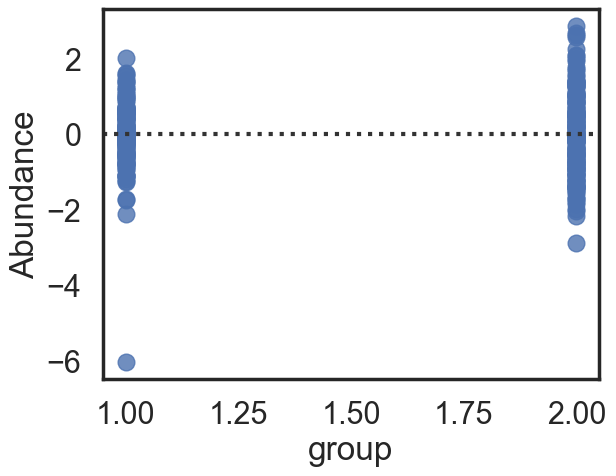

In [19]:
sns.residplot(
    data=values, x="group", y="Abundance")

In [20]:
X, y = quant_matrix_linregress.to_ml(feature_column="ProteinLabel")

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[:] = scaler.fit_transform(X[:])

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
clf = LogisticRegression()

clf.fit(X.values, y.values.ravel())

LogisticRegression()

In [24]:
from sklearn.inspection import permutation_importance


importances = permutation_importance(
    clf,
    X.values,
    y.values.ravel(),
    scoring="neg_log_loss",
    n_jobs=1,
    #max_samples=0.5,
    n_repeats=1,
)

In [25]:
feature_importances = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": importances['importances_mean']
    }
)

<Axes: xlabel='importance', ylabel='feature'>

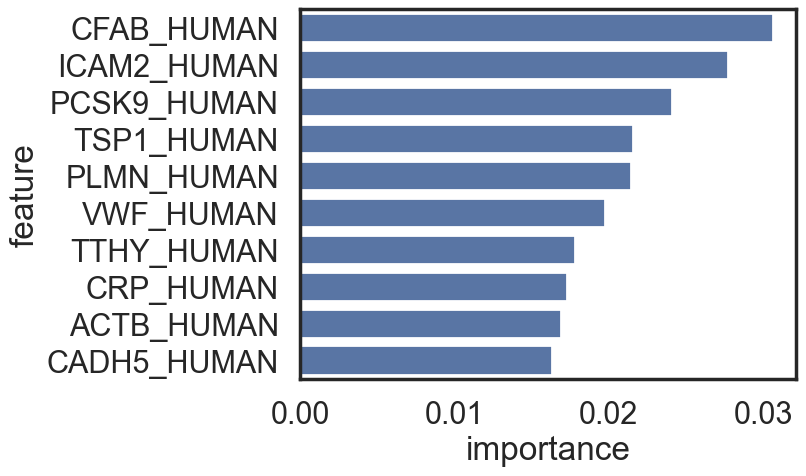

In [26]:
sns.barplot(x="importance", y="feature", data=feature_importances.sort_values("importance", ascending=False).head(10))

In [27]:
from dpks.interpretation import FeatureImportance

importance_calculator = FeatureImportance(
    n_iterations=100,
    feature_names=X.columns.values,
)

importance_calculator.fit(clf, X.values)

In [28]:
feature_importances['loss_importance'] = importance_calculator.global_explanations

<Axes: xlabel='loss_importance', ylabel='feature'>

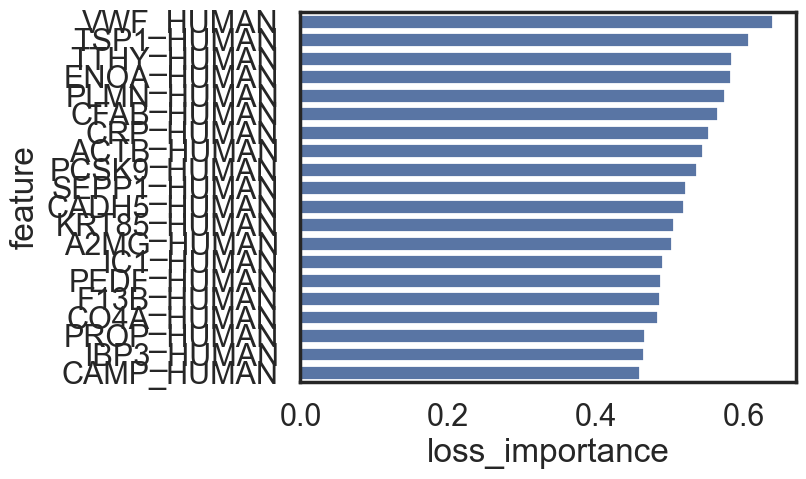

In [29]:
sns.barplot(
    data=feature_importances.sort_values("loss_importance", ascending=False).head(20),
    x="loss_importance",
    y="feature"
)

In [30]:
import shap
#%%
explainer = shap.LinearExplainer(clf, X)
#explainer = shap.TreeExplainer(clf)
#explainer = shap.Explainer(clf)
shap_values = explainer(X)
#%%
feature_importances['shap_importance'] = np.mean(abs(shap_values.values), axis=0)
#%%
feature_importances.sort_values("shap_importance", ascending=False)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,feature,importance,loss_importance,shap_importance
5,VWF_HUMAN,1.974749e-02,0.638486,0.627330
136,TSP1_HUMAN,2.158515e-02,0.605947,0.609093
270,TTHY_HUMAN,1.780368e-02,0.583522,0.576009
120,ENOA_HUMAN,1.372447e-02,0.582212,0.571478
47,PLMN_HUMAN,2.146039e-02,0.573802,0.568108
...,...,...,...,...
56,PZP_HUMAN,-1.345902e-05,0.005024,0.004998
236,POSTN_HUMAN,2.259433e-06,0.003034,0.003129
118,PON1_HUMAN,7.342679e-06,0.002937,0.002924
75,C163A_HUMAN,-9.564324e-06,0.001788,0.001789


<Axes: xlabel='shap_importance', ylabel='feature'>

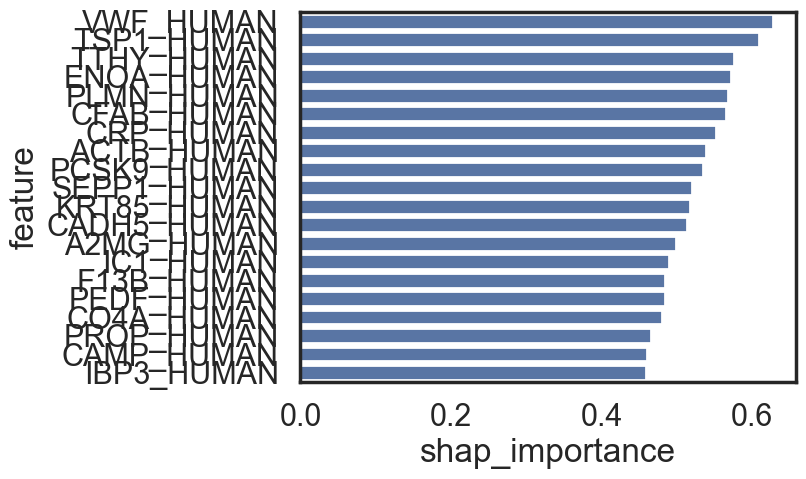

In [31]:
sns.barplot(
    data=feature_importances.sort_values("shap_importance", ascending=False).head(20),
    x="shap_importance",
    y="feature"
)

<Axes: xlabel='shap_importance', ylabel='loss_importance'>

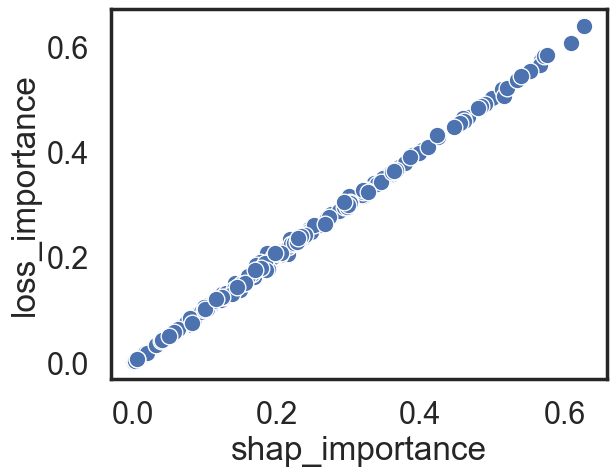

In [32]:

sns.scatterplot(
    data=feature_importances,
    x="shap_importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='loss_importance'>

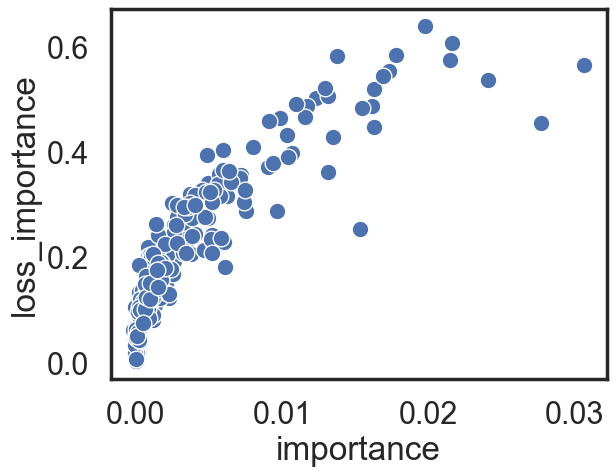

In [33]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="loss_importance",
)

In [34]:
feature_importances['coef_importance'] = np.abs(clf.coef_.ravel())

<Axes: xlabel='coef_importance', ylabel='loss_importance'>

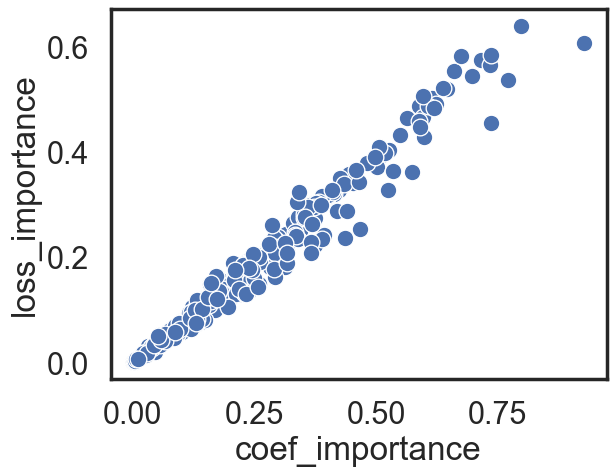

In [35]:
sns.scatterplot(
    data=feature_importances,
    x="coef_importance",
    y="loss_importance",
)